In [64]:

import random
import tensorflow as tf
import matplotlib.pyplot as plt

In [9]:
import xml.etree.ElementTree as ET
import csv


def get_labels_dict(data_path):
    labels_dict = {}
    with open(data_path + 'sci_labels.csv', 'r') as f:
        file = csv.reader(f)
        for row in file:
            labels_dict[row[0]] = row[1]
    return labels_dict


def get_features_labels(root, labels_dict):
    corpus = [] # each row is a string formed from all messages in a conversations
    labels = [] # each row is 0 or 1, corresponds to label for same row in corpus

    for conversation in root:
        string = " "
        for message in conversation:
            text = message.find('text').text
            if text is not None:
                string = string + "\r\n" + text 
        corpus.append(string)
        labels.append(int(labels_dict[conversation.get('id')]))
    return corpus, labels


In [10]:
train_data_path = '../../data/svm_training_data/'
training_xml = ET.parse(train_data_path + 'training_data.xml')
train_root = training_xml.getroot()

test_data_path = '../../data/svm_test_data/'
test_data_src = '../../data/pan12-sexual-predator-identification-test-corpus-2012-05-21/'
test_xml = ET.parse(test_data_src + 'pan12-sexual-predator-identification-test-corpus-2012-05-17.xml')
test_root = test_xml.getroot()

train_corpus, train_labels = get_features_labels(train_root, get_labels_dict(train_data_path))
test_corpus, test_labels = get_features_labels(test_root, get_labels_dict(test_data_path))

train_corpus_norm = []
train_corpus_susp = []
train_labels_norm = []
train_labels_susp = []
for index in range(len(train_corpus)):
    if train_labels[index] == 1:
        train_corpus_susp.append(train_corpus[index])
        train_labels_susp.append(train_labels[index])
    else:
        train_corpus_norm.append(train_corpus[index])
        train_labels_norm.append(train_labels[index])

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MaxAbsScaler
import scipy
# from sklearn.model_selection import train_test_split
import numpy as np

print('TODO: PLEASE REMOVE LIMITATION OF FIRST 1000 TEST CASES DONE DUE TO MEMORY ISSUES')

vectorizer = TfidfVectorizer()
_ = vectorizer.fit_transform(train_corpus)
X_train_all_unshuffled = vectorizer.transform(train_corpus)
X_train_norm = vectorizer.transform(train_corpus_norm)
X_train_susp = vectorizer.transform(train_corpus_susp)
# limiting to 1000 test cases due to memory issues
X_test = vectorizer.transform(test_corpus[:1000])

X_train_all_unshuffled = scipy.sparse.csr_matrix(X_train_all_unshuffled, dtype=np.float32)
y_train_all_unshuffled = np.array(train_labels)
X_train_norm = scipy.sparse.csr_matrix(X_train_norm, dtype=np.float32)
y_train_norm = np.array(train_labels_norm)
X_train_susp = scipy.sparse.csr_matrix(X_train_susp, dtype=np.float32)
y_train_susp = np.array(train_labels_susp)
X_test = scipy.sparse.csr_matrix(X_test, dtype=np.float32)
y_test = np.array(test_labels[:1000])

print(np.min(X_train_norm[:][0]))
print(np.max(X_train_norm[:][0]))
print(type(X_train_all_unshuffled))

scaler = MaxAbsScaler()
X_train_all_unshuffled = scaler.fit_transform(X_train_all_unshuffled)
X_train_norm = scaler.fit_transform(X_train_norm)
X_train_susp = scaler.fit_transform(X_train_susp)
X_test = scaler.fit_transform(X_test)
X_train_all_unshuffled.data -= 0.5
X_train_norm.data -= 0.5
X_train_susp.data -= 0.5
X_test.data -= 0.5
X_train_all_unshuffled.data *= 2
X_train_norm.data *= 2
X_train_susp.data *= 2
X_test.data *= 2

print(np.min(X_train_norm[:][0]))
print(np.max(X_train_norm[:][0]))

TODO: PLEASE REMOVE LIMITATION OF FIRST 1000 TEST CASES DONE DUE TO MEMORY ISSUES
0.0
0.44709805
<class 'scipy.sparse.csr.csr_matrix'>
-0.96498847
1.0


In [51]:
print(X_train_all_unshuffled.shape)
print(y_train_all_unshuffled.shape)

(14703, 121394)
(14703,)


In [52]:
# Shuffling the training data and its labels


index = np.arange(np.shape(X_train_all_unshuffled)[0])
print (index)
np.random.shuffle(index)
X_train_all = X_train_all_unshuffled[index, :]
y_train_all = y_train_all_unshuffled[index]

[    0     1     2 ... 14700 14701 14702]


In [53]:
print((X_train_all).shape)

(14703, 121394)


In [54]:
X_train_all = np.reshape(X_train_all, (X_train_all.shape[0], X_train_all.shape[1], -1))
print(X_train_all.shape)


(14703, 121394)


In [55]:

# Since the input data is in sparse matrix form, this function is used to convert it to sparse tensors.
def csr_to_sparsetensor(X):
    t = X.nonzero()
    a2 = []
    for i in range(len(t[0])):
        a2.append([t[0][i], t[1][i]])
    a2 = sorted(a2,key=lambda x: (x[0],x[1]))
    return tf.SparseTensorValue(a2, X.data, list(X.shape))


In [56]:
def create_placeholders():
    X = tf.placeholder(tf.float32, shape = [None, 121394, 1])
    Y = tf.placeholder(tf.float32, shape=[None, 1])
    keep_prob_conv = tf.placeholder(tf.float32)
    keep_prob_FC = tf.placeholder(tf.float32)
    return X,Y, keep_prob_conv, keep_prob_FC


In [57]:
def initialize_parameters(beta = 0.0):

    #Regularization
    if beta!=0:
        regularizer = tf.contrib.layers.l2_regularizer(scale=beta)
    else: regularizer=None

    W1 = tf.get_variable("W1", [16, 1, 8], regularizer=regularizer,
                         initializer=tf.contrib.layers.xavier_initializer())
    W2 = tf.get_variable("W2", [8, 8, 16], regularizer=regularizer,
                         initializer=tf.contrib.layers.xavier_initializer())

    parameters = {"W1": W1, "W2": W2}

    return parameters, regularizer

In [58]:
def forward_propagation(X, parameters, keep_prob_conv, keep_prob_FC, type = "train", regularizer = None):
    W1 = parameters['W1']
    W2 = parameters['W2']

   # X = tf.sparse.to_dense(x, default_value=0)
    
#     with tf.Session() as sess2:
#         print(sess2.run(X))
#         print(sess2.run(X.shape))
    
#     s = tf.shape(X)
#     print(s)
#     X = tf.reshape(X, )
    Z1 = tf.nn.conv1d(X, W1, stride=4, padding='SAME', name="Z1")
    #print("Successfully finished first convolution")
    print("Z1 shape", Z1.shape)
    A1 = tf.nn.relu(Z1, name="A1")
    D1 = tf.nn.dropout(A1, keep_prob=keep_prob_conv)

    P1 = tf.layers.max_pooling1d(D1, pool_size = 4, strides=4, padding='SAME', name="P1")
    print("P1 Shape: ", P1.shape)
    Z2 = tf.nn.conv1d(P1, W2, stride=2, padding='SAME', name="Z2")
    print("Successfully finished second convolution")
    
    
    print("Z2 shape",Z2.shape)
    A2 = tf.nn.relu(Z2, name="A2")
    D2 = tf.nn.dropout(A2, keep_prob=keep_prob_conv)

    P2 = tf.layers.max_pooling1d(D2, pool_size = 4, strides=4, padding='SAME', name="P2")
    print("P2 Shape:", P2.shape)
    print("Successfully finished second pooling")
    
    P2 = tf.contrib.layers.flatten(P2)
    print(P2.shape)
    print("P2 Shape after flattening:" , P2.shape)
    D2 = tf.nn.dropout(P2, keep_prob=keep_prob_FC)
    Z4 = tf.contrib.layers.fully_connected(D2, 25, normalizer_fn=tf.contrib.layers.batch_norm, weights_regularizer = regularizer)

    print("Z4 shape: ", Z4.shape)

    D3 = tf.nn.dropout(Z4, keep_prob=keep_prob_FC)

    Z5 = tf.contrib.layers.fully_connected(D3, 1, weights_regularizer = regularizer, activation_fn=None, normalizer_fn=tf.contrib.layers.batch_norm)
    print("Z5 Shape : ", Z5.shape)

    return Z5






In [59]:
def find_cost(Z5, Y, regularizer=None):
    print(Z5.shape, Y.shape)

    cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(logits=Z5, labels=Y)
    print (cross_entropy)
    cost = tf.reduce_mean(cross_entropy,name = "cost")

    if regularizer is not None:
        reg_variables = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
        reg_term = tf.contrib.layers.apply_regularization(regularizer, reg_variables)
    else:
        reg_term = 0

    cost += reg_term

    print(cost)
    return cost


In [60]:
def random_mini_batches(X, Y, mini_batch_size=32):
    
    
    m = X.shape[0]  # number of training examples
    mini_batches = []
    #X = np.reshape(X, (X.shape[0], X.shape[1], -1))

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation, :]
    shuffled_Y = Y[permutation]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(m / mini_batch_size)  # number of mini batches of size mini_batch_size in partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size: k * mini_batch_size + mini_batch_size, :]
        mini_batch_Y = shuffled_Y[k * mini_batch_size: k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size: m, :]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size: m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [61]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [73]:
def model(X_t, Y_t, X_test, Y_test, learning_rate = 0.009, num_epochs = 11, minibatch_size = 16, keep_prob_conv = 1, keep_prob_fc = 0.7, mode = "train"):
    tf.reset_default_graph()
    
    costs = list()
    # Here keep_prob is a float value, while kp is its tensor
    X, Y, kp_conv, kp_fc = create_placeholders()
    m = X_t.shape[0]
    print(tf.shape(X))
    parameters,regularizer = initialize_parameters()
    Z5 = forward_propagation(X, parameters, kp_conv, kp_fc, regularizer=regularizer)
    cost = find_cost(Z5, Y, regularizer)
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    costs = list()
    epoch_list = list()
    if mode == "train":
        with tf.Session() as sess:
            sess.run(init)
#             temporary_test = tf.sparse.to_dense(X, default_value=0)
#             print(sess.run(temporary_test))
            saver = tf.train.Saver()
            for epoch in range(num_epochs):

                minibatch_cost = 0.
                num_minibatches = int(m / minibatch_size)  # number of minibatches of size minibatch_size in the train set
                
                minibatches = random_mini_batches(X_t, Y_t, minibatch_size)

                for minibatch in minibatches:
                    # Select a minibatch
                    (minibatch_X, minibatch_Y) = minibatch
                    # Converts X from Sparse Matrix to Dense Matrix and then creates minibatches
                    minibatch_X = scipy.sparse.csr_matrix.todense(minibatch_X)
                    minibatch_X = minibatch_X[:, :, np.newaxis]
                    minibatch_Y = minibatch_Y[:,np.newaxis]
                    #print(minibatch_Y.shape)
                    _, temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, kp_conv: keep_prob_conv, kp_fc:keep_prob_fc})

                    minibatch_cost += temp_cost / num_minibatches
                    
                epoch_list.append(epoch)
                #costs.append(minibatch_cost)
                # Print the cost every 5 epochs
                if epoch % 5 == 0:
                    print("Cost after epoch %i: %f" % (epoch, minibatch_cost))
                if epoch % 1 == 0:
                    costs.append(minibatch_cost)

            print("Finished Training")
            saver.save(sess, './my_model')
            #print("Cost: ", sess.run(cost, feed_dict={X: X_t, Y: Y_t,kp: 1.0}))
            plt.plot(epoch_list, costs)
            plt.xlabel("Epochs")
            plt.ylabel("Costs")
            plt.show()
            
            
    prepredictions = list()
    
    if mode == "test":
        
        num_minibatches = int(m / minibatch_size)
        with tf.Session() as sess:
            saver = tf.train.Saver()
            saver.restore(sess, './my_model')
            minibatches = random_mini_batches(X_test, Y_test, minibatch_size)
            #sess.run(init)
            minibatch_cost = 0.
            for minibatch in minibatches:
                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # Converts X from Sparse Matrix to Dense Matrix and then creates minibatches
                minibatch_X = scipy.sparse.csr_matrix.todense(minibatch_X)
                minibatch_X = minibatch_X[:, :, np.newaxis]
                minibatch_Y = minibatch_Y[:,np.newaxis]
                #print(minibatch_Y.shape)
                #_, temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y, kp_conv: keep_prob_conv, kp_fc:keep_prob_fc})

                #minibatch_cost += temp_cost / num_minibatches

                prepredictions.append((minibatch_Y, sigmoid(sess.run(Z5, feed_dict={X: minibatch_X, Y: minibatch_Y, kp_conv: 1, kp_fc:1}))))
                #print(prepredictions)
    return parameters, prepredictions


In [63]:

#def model(X_t, Y_t, X_test, Y_test, learning_rate = 0.09, num_epochs = 1, minibatch_size = 16, keep_prob_conv = 1, keep_prob_fc = 0.7, mode = "train"):
    
#             num_minibatches = int(m / minibatch_size)
#             prepredictions = sess.run(Z5,
#                                       feed_dict={X: X_t[0:minibatch_size, :, :, :],
#                                                  Y: Y_t[0: minibatch_size, :],
#                                                  kp_conv: 1, kp_fc: 1})
#             for i in range(1,num_minibatches):
#                 prepredictions = np.append(prepredictions, sess.run(Z5, feed_dict={
#                     X: X_t[i * minibatch_size: i * minibatch_size + minibatch_size, :, :, :],
#                     Y: Y_t[i * minibatch_size: i * minibatch_size + minibatch_size, :], kp_conv: 1, kp_fc:1}), axis = 0)

#             if m % minibatch_size != 0:
#                 prepredictions = np.append(prepredictions, sess.run(Z5, feed_dict={
#                     X: X_t[num_minibatches * minibatch_size: m, :, :, :],
#                     Y: Y_t[num_minibatches * minibatch_size: m, :], kp_conv: 1, kp_fc:1}), axis=0)



#             predicted_result = np.argmax(prepredictions,1)
#             m = X_t.shape[0]

#             random_result = np.reshape(np.random.randint(2, size = m), (m, 1))


#             TP = np.sum(np.asarray([1 for i in range(m) if predicted_result[i]==1 and Y_t[i]==1]))
#             TN = np.sum(np.asarray([1 for i in range(m) if predicted_result[i]==0 and Y_t[i]==1]))
#             FP = np.sum(np.asarray([1 for i in range(m) if predicted_result[i]==1 and Y_t[i]==1]))
#             FN = np.sum(np.asarray([1 for i in range(m) if predicted_result[i]==0 and Y_t[i]==1]))
#             print(TP, TN, FP, FN)
#             balance_accuracy = (1/2) * (((TP)/(TP+FN))+((TN)/(TN+FP)))

#             print("Balance Accuracy = ", balance_accuracy)

#             ##TESTING THE TESTING SET


#             m = X_test.shape[0]
#             num_minibatches = int(m / minibatch_size)
#             prepredictions_test = sess.run(Z5,
#                                       feed_dict={X: X_test[0:minibatch_size, :, :, :],
#                                                  Y: Y_test[0: minibatch_size, :],
#                                                  kp_conv: 1, kp_fc: 1})
#             for i in range(1, num_minibatches):
#                 prepredictions_test = np.append(prepredictions_test, sess.run(Z5, feed_dict={
#                     X: X_test[i * minibatch_size: i * minibatch_size + minibatch_size, :, :],
#                     Y: Y_test[i * minibatch_size: i * minibatch_size + minibatch_size], kp_conv: 1, kp_fc: 1}), axis=0)

#             if m % minibatch_size != 0:
#                 prepredictions_test = np.append(prepredictions_test, sess.run(Z5, feed_dict={
#                     X: X_test[num_minibatches * minibatch_size: m, :, :],
#                     Y: Y_test[num_minibatches * minibatch_size: m], kp_conv: 1, kp_fc: 1}), axis=0)

#             predicted_result_test = np.argmax(prepredictions_test, 1)


#             random_result = np.reshape(np.random.randint(2, size=m), (m, 1))


#             TP_test = np.sum(np.asarray([1 for i in range(m) if predicted_result_test[i] == 1 and Y_test[i] == 1]))
#             TN_test = np.sum(np.asarray([1 for i in range(m) if predicted_result_test[i] == 0 and Y_test[i] == 1]))
#             FP_test = np.sum(np.asarray([1 for i in range(m) if predicted_result_test[i] == 1 and Y_test[i] == 1]))
#             FN_test = np.sum(np.asarray([1 for i in range(m) if predicted_result_test[i] == 0 and Y_test[i] == 1]))
#             print(TP_test, TN_test, FP_test, FN_test)
#             balance_accuracy_test = (1 / 2) * (((TP_test) / (TP_test + FN_test)) + ((TN_test) / (TN_test + FP_test)))

#             print("Balance Accuracy_test = ", balance_accuracy_test)



Tensor("Shape:0", shape=(3,), dtype=int32)
Z1 shape (?, 30349, 8)
P1 Shape:  (?, 7588, 8)
Successfully finished second convolution
Z2 shape (?, 3794, 16)
P2 Shape: (?, 949, 16)
Successfully finished second pooling
(?, 15184)
P2 Shape after flattening: (?, 15184)
Z4 shape:  (?, 25)
Z5 Shape :  (?, 1)
(?, 1) (?, 1)
Tensor("logistic_loss:0", shape=(?, 1), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
Cost after epoch 0: 0.212759
Cost after epoch 5: 0.109621
Cost after epoch 10: 0.107392
Finished Training


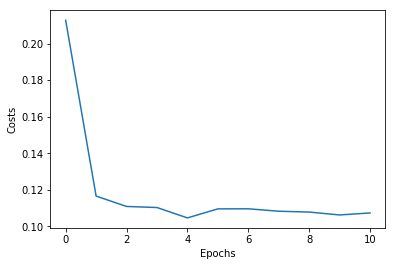

{'W1': <tf.Variable 'W1:0' shape=(16, 1, 8) dtype=float32_ref>, 'W2': <tf.Variable 'W2:0' shape=(8, 8, 16) dtype=float32_ref>}


In [78]:
parameters, prepredictions = model(X_train_all, y_train_all, X_test, y_test)
print(parameters)

[]


In [90]:
# Testing Model

_, prepredictions = model(X_train_all, y_train_all, X_test, y_test,  mode = "test")

Tensor("Shape:0", shape=(3,), dtype=int32)
Z1 shape (?, 30349, 8)
P1 Shape:  (?, 7588, 8)
Successfully finished second convolution
Z2 shape (?, 3794, 16)
P2 Shape: (?, 949, 16)
Successfully finished second pooling
(?, 15184)
P2 Shape after flattening: (?, 15184)
Z4 shape:  (?, 25)
Z5 Shape :  (?, 1)
(?, 1) (?, 1)
Tensor("logistic_loss:0", shape=(?, 1), dtype=float32)
Tensor("add:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from ./my_model


In [91]:
print(prepredictions)

[(array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]]), array([[0.02234191],
       [0.33782881],
       [0.02773527],
       [0.03594635],
       [0.02656033],
       [0.05790543],
       [0.02595134],
       [0.06026016],
       [0.07134534],
       [0.02298567],
       [0.05565762],
       [0.03254948],
       [0.0106489 ],
       [0.02835509],
       [0.03921336],
       [0.0035162 ]], dtype=float32)), (array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]]), array([[0.02661193],
       [0.02668813],
       [0.02689407],
       [0.02872956],
       [0.02784439],
       [0.0271851 ],
       [0.02419686],
       [0.02839424],
       [0.02751993],
       [0.62774426],
       [0.02809849],
       [0.02557663],
   

In [92]:
total = 0
misclassified = 0
for pair in prepredictions:
    
    label = pair[0]
    total += label.shape[0]
    pred = np.round(pair[1])
    misclassified += np.sum(np.absolute(pred - label))
    
print(1- misclassified/total)

0.986
